In [11]:

import xarray as xr
import xdem
import glob
import geopandas as gpd
import pandas as pd
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')

import matplotlib.pyplot as plt
from shapely import ops

import geoutils as gu
import numpy as np


import geocube.vector
import datetime as dt
from rasterio.enums import Resampling
import xdem

import altair as alt

import rioxarray as rix

# Open DEM, DTM, and polygon datasets

In [12]:
dem_fn =  "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/2015_09_01.tif"
# dtm_fn = '/data2/elilouis/hsfm-geomorph/data/reference_dem_highres/baker/raw_tifs/baker_2015/2015_dtm_10m.tif'
dtm_fn = '  '

save_slope_fn = '/data2/elilouis/hsfm-geomorph/data/reference_dem_highres/baker/raw_tifs/baker_2015/2015_slope.tif'
erosion_polys_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/**/erosion.geojson", recursive=True)
erosion_polys_fns = [f for f in erosion_polys_fns if 'improvements' not in f]
streamstats_watersheds_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/streamstats_watersheds/*.geojson")
glacier_polys_fns = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/**/glaciers.geojson", recursive=True)

strip_time_format = "%Y_%m_%d"

In [13]:
erosion_polys_gdf = pd.concat([
    gpd.read_file(f) for f in erosion_polys_fns
])[['name', 'type', 'geometry']]

In [14]:
dtm = xdem.DEM(dtm_fn)
dem = xdem.DEM(dem_fn)

In [15]:
slope = xdem.terrain.slope(dtm)

In [ ]:
slope.save(save_slope_fn)


In [6]:
darea_xr = rix.open_rasterio("drainage_area.tif")

In [7]:
streamstats_watersheds_gdf = pd.concat([
    gpd.read_file(f).assign(name=f.split('/')[-1].split('.')[0].capitalize()) for f in streamstats_watersheds_fns
]).query("id == 'globalwatershed'").reset_index(drop=True).to_crs(dtm.crs)

In [8]:
glaciers_gdf = pd.concat([gpd.read_file(f) for f in glacier_polys_fns])
glaciers_gdf = glaciers_gdf[glaciers_gdf['year'].apply(lambda x: type(x)==str and len(x) > 0)]
glaciers_gdf['date'] = glaciers_gdf['year'].apply(lambda x: dt.datetime.strptime(x, strip_time_format))

# Examine slope distribution within the combined fluvial+hillslope domains

In [9]:
slope_xr = slope.to_xarray()
slope_xr.name = 'slope'

In [10]:
slope_df = pd.DataFrame()
for name in erosion_polys_gdf.name.unique():
    slope_xr_clipped_fluvial = slope_xr.rio.clip(erosion_polys_gdf.query(f"name == '{name}'").query("type == 'fluvial'").geometry).to_dataframe().reset_index().dropna().assign(type='fluvial').assign(name=name)
    slope_xr_clipped_hillslope = slope_xr.rio.clip(erosion_polys_gdf.query(f"name == '{name}'").query("type == 'hillslope'").geometry).to_dataframe().reset_index().dropna().assign(type='hillslope').assign(name=name)
    slope_df = pd.concat([slope_df, slope_xr_clipped_fluvial, slope_xr_clipped_hillslope])

In [11]:
alt.Chart(
    slope_df
).transform_density(
    'slope',
    as_ = ['slope', 'density'],
    groupby = ['name'],
    counts = True
).mark_area(opacity=0.5, color='gray').encode(
    alt.X("slope:Q"),
    alt.Y('density:Q'),
    alt.Facet('name:N', columns=4, title='Valley'),
).properties(height=150, title='Slope Distributions in Geomorphic Process Domains')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [12]:
alt.Chart(
    slope_df
).transform_density(
    'slope',
    as_ = ['slope', 'density'],
    groupby = ['type', 'name'],
    counts = True
).mark_area(opacity=0.5).encode(
    alt.X("slope:Q"),
    alt.Y('density:Q'),
    alt.Color("type:N"),
    alt.Facet('name:N', columns=4, title='Valley'),
).properties(height=150, title='Slope Distributions in Geomorphic Process Domains')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [13]:
alt.Chart(
    slope_df
).transform_density(
    'slope',
    as_ = ['slope', 'density'],
    groupby = ['type', 'name'],
    counts = False
).mark_area(opacity=0.5).encode(
    alt.X("slope:Q"),
    alt.Y('density:Q'),
    alt.Color("type:N"),
    alt.Facet('name:N', columns=4, title='Valley'),
).properties(height=150, title='Slope Distributions in Geomorphic Process Domains')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


# Automatic delination: hillslope vs fluvial distinction and bareground/measurable area


### Combine fluvial and hillslope domains into a "bareground/measurable area" polygon

In [14]:
valleys = [
    'Deming', 'Rainbow', 'Coleman', 'Mazama', 'Boulder', 'Squak', 'Thunder', 'Park', 'Talum', 'Easton',
]
SLOPE_THRESHOLD = 20

In [15]:
manual_bareground_polygons = {}
for valley in valleys:
    manual_bareground_polygons[valley] = ops.unary_union(erosion_polys_gdf.query(f"name == '{valley}'").geometry)

### Split into two domains using slopethreshold

In [16]:
slope_rasters_bareground = {}
slope_rasters_bareground_hillslope = {}
slope_rasters_bareground_fluvial = {}
for name, bareground_polygon in manual_bareground_polygons.items():
    slope_raster = slope_xr.rio.clip([bareground_polygon])
    slope_rasters_bareground[name] = slope_raster
    slope_rasters_bareground_hillslope[name] = slope_raster.where(slope_raster >= SLOPE_THRESHOLD)
    slope_rasters_bareground_fluvial[name] = slope_raster.where(slope_raster < SLOPE_THRESHOLD)

## Split into two domains using drainage area threshold

In [17]:
DAREA_THRESHOLD = 11000

In [18]:
darea_rasters_bareground = {}
darea_rasters_bareground_hillslope = {}
darea_rasters_bareground_fluvial = {}
for name, bareground_polygon in manual_bareground_polygons.items():
    darea_raster = darea_xr.rio.clip([bareground_polygon])
    darea_rasters_bareground[name] = darea_raster
    darea_rasters_bareground_hillslope[name] = darea_raster.where(darea_raster < DAREA_THRESHOLD)
    darea_rasters_bareground_fluvial[name] = darea_raster.where(darea_raster >= DAREA_THRESHOLD)

## Look at slope rasters

### For the manually delineated "bareground" areas

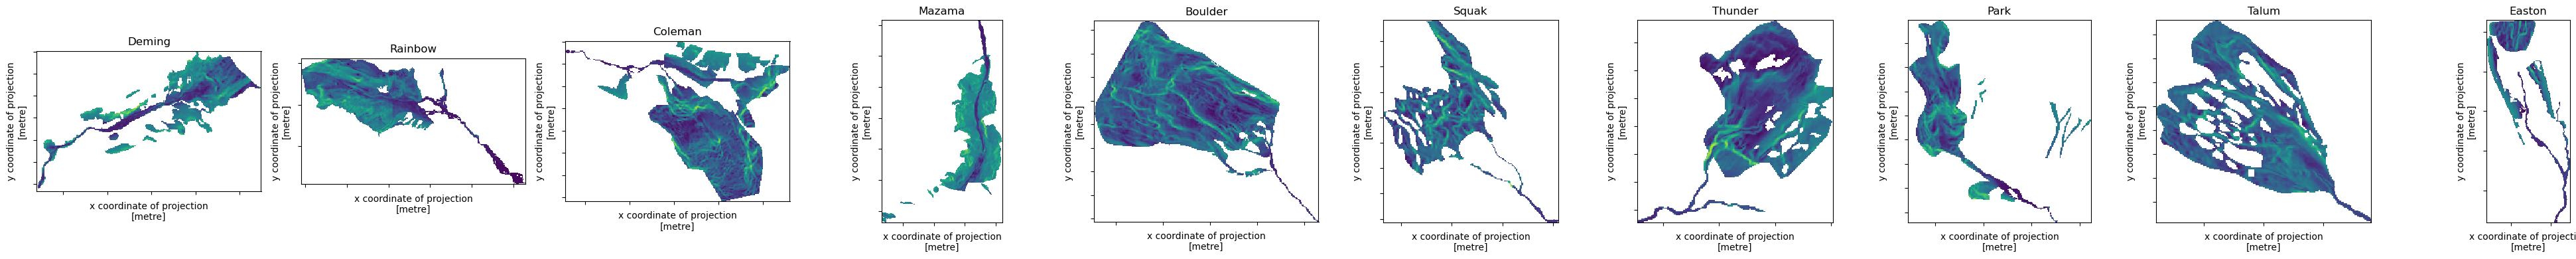

In [19]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_bareground.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

### For the slope-thresholded hillslope portions of the manually delineated "bareground" areas

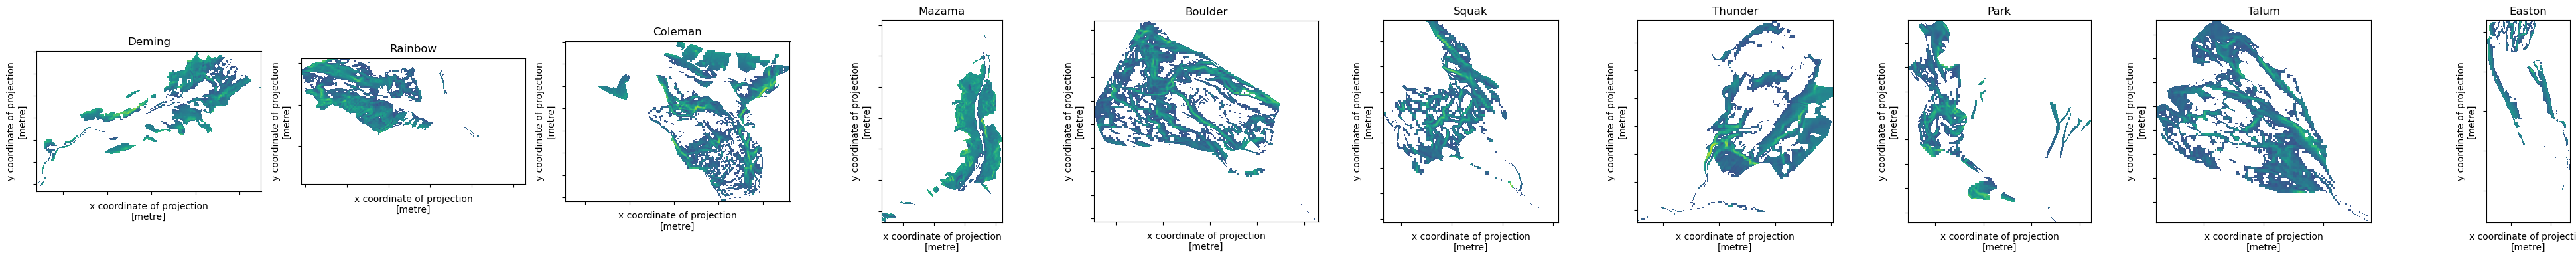

In [20]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_bareground_hillslope.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

### For the slope-thresholded fluvial portions of the manually delineated "bareground" areas

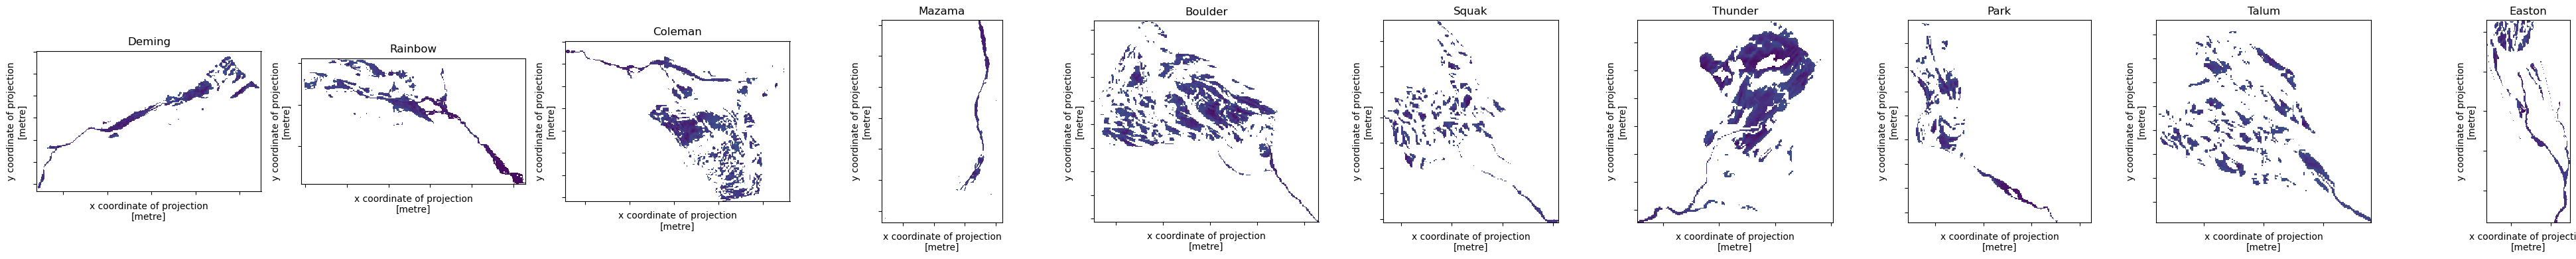

In [21]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_bareground_fluvial.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

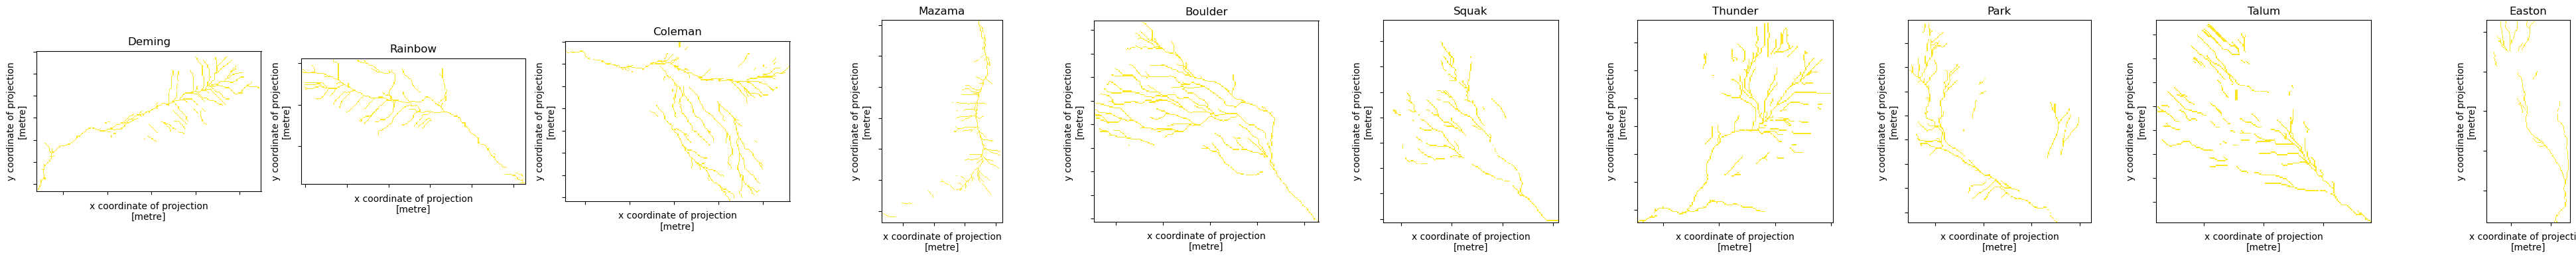

In [22]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(darea_rasters_bareground_fluvial.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

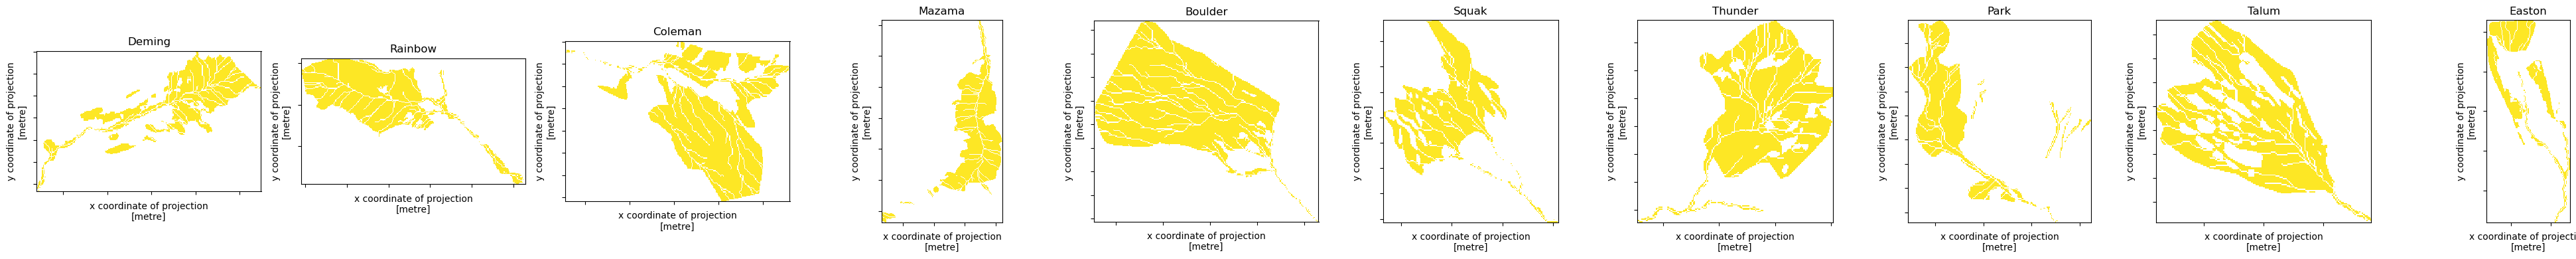

In [23]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(darea_rasters_bareground_hillslope.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

## Delineate using ESA WorldCover and a slopethreshold

### Create "bareground/measurable area" polygon with ESA WorldCover "Bareground" and "moss/lichen" classes

In [24]:
esa_worldcover_fn = '/data2/elilouis/hsfm-geomorph/data/ESA_WorldCover_10m_2020_V1/ESA_WorldCover_10m_2020_v100_N48W123/ESA_WorldCover_10m_2020_v100_N48W123_Map.tif'
esa_worldcover_xr = rix.open_rasterio(esa_worldcover_fn, chunks=True)

In [25]:
esa_worldcover_rasters_clipped = {}
esa_worldcover_vectors_clipped = {}

for valley in valleys:
    # clip to watershed
    esa_bareground_raster = esa_worldcover_xr.rio.clip(
        streamstats_watersheds_gdf.query(f"name == '{valley}'").to_crs(esa_worldcover_xr.rio.crs).geometry
    ).rio.reproject(streamstats_watersheds_gdf.crs)
    # isolate "bareground" and "moss/lichen" classes
    esa_bareground_raster = esa_bareground_raster.where(
        (esa_bareground_raster == 60) | (esa_bareground_raster == 100)
    )

    esa_worldcover_rasters_clipped[valley] = esa_bareground_raster
    
    esa_worldcover_vectorized = geocube.vector.vectorize(esa_bareground_raster.astype("float32"))
    esa_worldcover_vectorized['class'] = esa_worldcover_vectorized[None]
    esa_worldcover_vectorized = esa_worldcover_vectorized[esa_worldcover_vectorized['class'].isin([60,100])]
    esa_worldcover_vectors_clipped[valley] = ops.unary_union(esa_worldcover_vectorized.geometry)

### Split into two domains using slope threshold

In [26]:
slope_rasters_esabareground = {}
slope_rasters_esabareground_hillslope = {}
slope_rasters_esabareground_fluvial = {}

for valley in valleys:
    raster = slope_xr.rio.clip([esa_worldcover_vectors_clipped[valley]]).rio.clip(glaciers_gdf.geometry, invert=True)
    slope_rasters_esabareground[valley] = raster
    slope_rasters_esabareground_hillslope[valley] = raster.where(raster >= SLOPE_THRESHOLD)
    slope_rasters_esabareground_fluvial[valley] = raster.where(raster < SLOPE_THRESHOLD)

### Limit ESA-bareground-based slope rasters to "proglacial areas" if we have one defined for that valley

In [27]:
proglacial_boundaries_gdf = gpd.read_file('/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/proglacial_boundaries.geojson')

In [28]:
proglacial_boundaries_gdf

,id,name,geometry
0,NaN,Deming,"MULTIPOLYGON (((584055.153 5401078.115, 584092..."
1,NaN,Easton,"MULTIPOLYGON (((585209.161 5398985.463, 585195..."
2,NaN,Rainbow,"MULTIPOLYGON (((590647.104 5406045.754, 590797..."
3,NaN,Coleman,"MULTIPOLYGON (((585248.445 5406118.836, 584777..."
4,NaN,Mazama,"MULTIPOLYGON (((588864.369 5407206.578, 588964..."


In [29]:
for name in valleys:
    proglacial_boundaries = proglacial_boundaries_gdf.query(f"name == '{name}'").geometry
    if len(proglacial_boundaries) > 0:    
        slope_rasters_esabareground[name] = slope_rasters_esabareground[name].rio.clip(proglacial_boundaries_gdf.query(f"name == '{name}'").geometry)
        slope_rasters_esabareground_hillslope[name] = slope_rasters_esabareground_hillslope[name].rio.clip(proglacial_boundaries_gdf.query(f"name == '{name}'").geometry)
        slope_rasters_esabareground_fluvial[name] = slope_rasters_esabareground_fluvial[name].rio.clip(proglacial_boundaries_gdf.query(f"name == '{name}'").geometry)

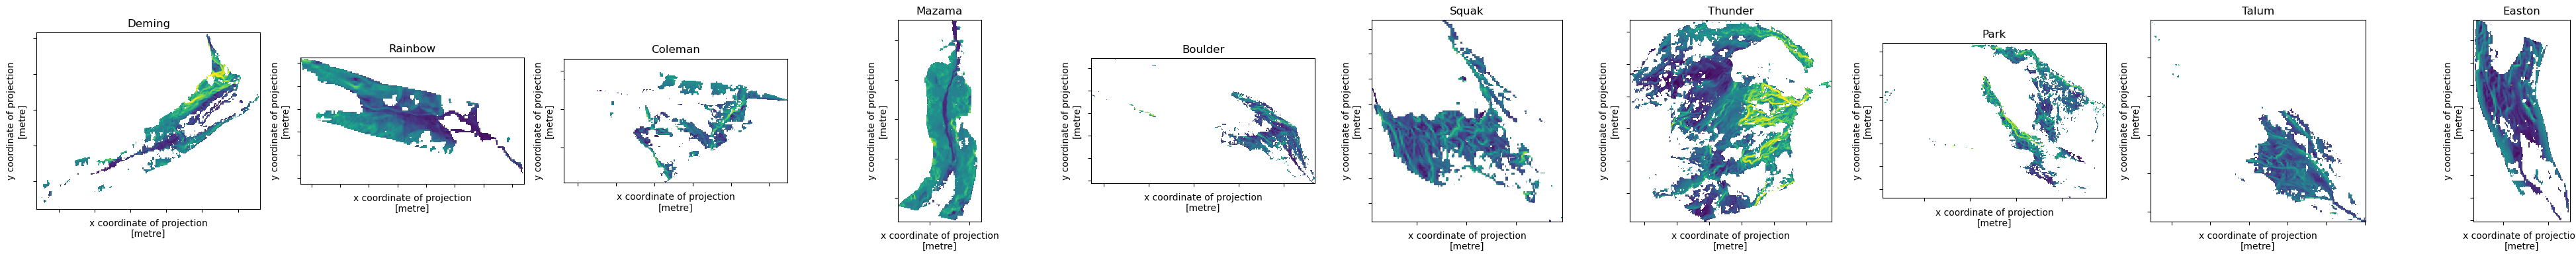

In [30]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_esabareground.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

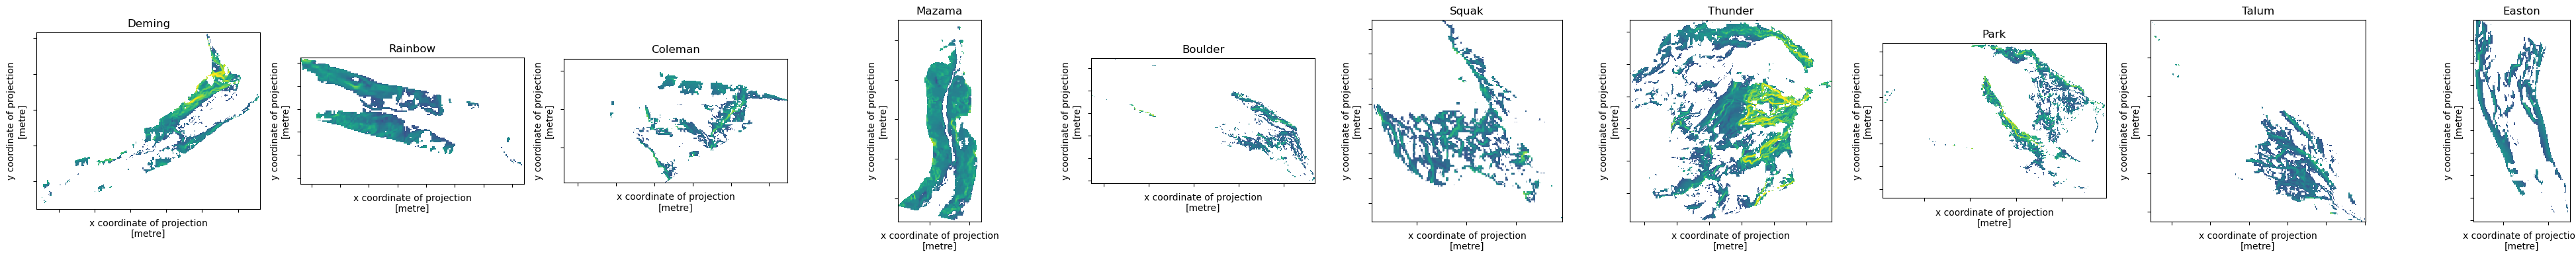

In [31]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_esabareground_hillslope.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

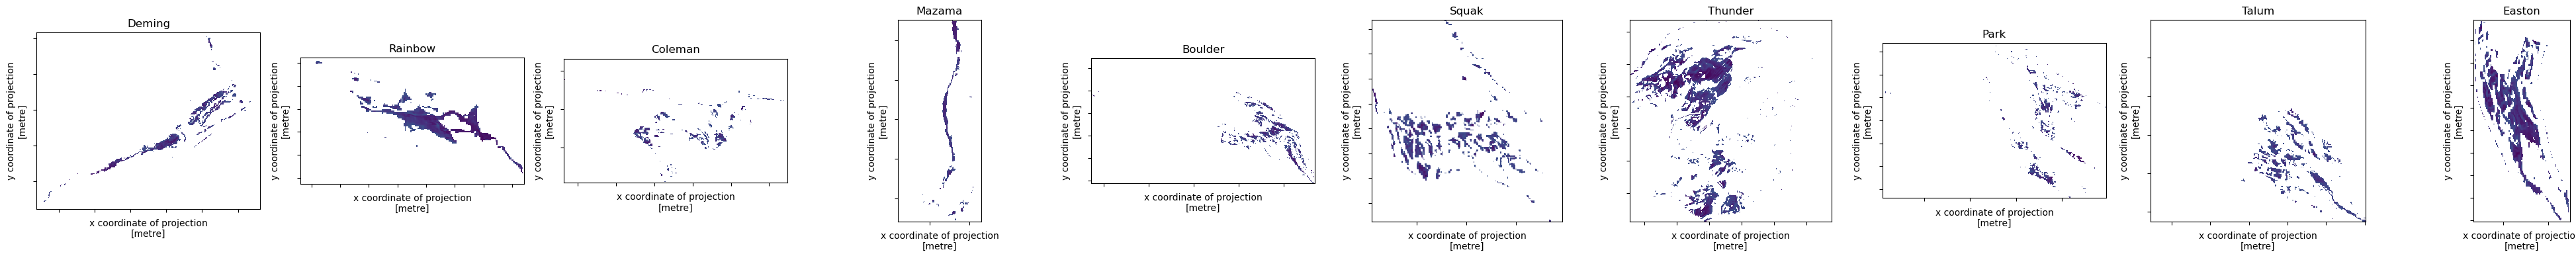

In [32]:
fig, axes = plt.subplots(1,10, figsize=(40,4))
for i, (valley_name, raster) in enumerate(slope_rasters_esabareground_fluvial.items()):
    im = raster.rio.clip(
        glaciers_gdf[glaciers_gdf.date.dt.year.isin([1947, 2015])].geometry,
        invert=True
    ).plot(ax=axes[i], vmin=0, vmax=80, add_colorbar=False)
    axes[i].set_title(valley_name)
    axes[i].set_aspect('equal')
    axes[i].set_xticklabels([])
    axes[i].set_yticklabels([])
plt.tight_layout()

## Create 2 types of automatically-generated erosion polygons

In [33]:
automated_delineation_hillslope_polygons = {}
automated_delineation_fluvial_polygons = {}
darea_automated_delineation_hillslope_polygons = {}
darea_automated_delineation_fluvial_polygons = {}
automated_bareground_and_delineation_hillslope_polygons = {}
automated_bareground_and_delineation_fluvial_polygons = {}

for valley in valleys:
    slope_raster_bgnd_hill = slope_rasters_bareground_hillslope[valley]
    slope_raster_bgnd_fluv = slope_rasters_bareground_fluvial[valley]

    darea_raster_bgnd_hill = darea_rasters_bareground_hillslope[valley]
    darea_raster_bgnd_fluv = darea_rasters_bareground_fluvial[valley]

    slope_raster_esabgnd_hill = slope_rasters_esabareground_hillslope[valley]
    slope_raster_esabgnd_fluv = slope_rasters_esabareground_fluvial[valley]

    slope_raster_bgnd_hill.rio._nodata = np.nan
    slope_raster_bgnd_hill.attrs['nodata'] = np.nan
    slope_raster_bgnd_fluv.rio._nodata = np.nan
    slope_raster_bgnd_fluv.attrs['nodata'] = np.nan

    darea_raster_bgnd_hill.rio._nodata = np.nan
    darea_raster_bgnd_hill.attrs['nodata'] = np.nan
    darea_raster_bgnd_fluv.rio._nodata = np.nan
    darea_raster_bgnd_fluv.attrs['nodata'] = np.nan

    slope_raster_esabgnd_hill.rio._nodata = np.nan
    slope_raster_esabgnd_hill.attrs['nodata'] = np.nan
    slope_raster_esabgnd_fluv.rio._nodata = np.nan
    slope_raster_esabgnd_fluv.attrs['nodata'] = np.nan

    automated_delineation_hillslope_polygons[valley] = ops.unary_union(geocube.vector.vectorize(slope_raster_bgnd_hill.astype("float32")).geometry).buffer(10).simplify(10)
    automated_delineation_fluvial_polygons[valley] = ops.unary_union(geocube.vector.vectorize(slope_raster_bgnd_fluv.astype("float32")).geometry).buffer(10).simplify(10)

    darea_automated_delineation_hillslope_polygons[valley] = ops.unary_union(geocube.vector.vectorize(darea_raster_bgnd_hill.astype("float32")).geometry).buffer(10).simplify(10)
    darea_automated_delineation_fluvial_polygons[valley] = ops.unary_union(geocube.vector.vectorize(darea_raster_bgnd_fluv.astype("float32")).geometry).buffer(10).simplify(10)

    automated_bareground_and_delineation_hillslope_polygons[valley] = ops.unary_union(geocube.vector.vectorize(slope_raster_esabgnd_hill.astype("float32")).geometry)
    automated_bareground_and_delineation_fluvial_polygons[valley] = ops.unary_union(geocube.vector.vectorize(slope_raster_esabgnd_fluv.astype("float32")).geometry)

## Combine 3 types of erosion polygons - totally manual, manual bareground and automatic fluvial/hillslope distinction, automatic bareground and atuomatic fluvial/hillslope distinction

### Open totally manual polygons

In [34]:
all_erosion_files = glob.glob("/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/*/erosion.geojson")
erosion_polygon_gdf = gpd.GeoDataFrame(pd.concat([gpd.read_file(f) for f in all_erosion_files]))

In [35]:
all_types_erosion_polygons_gdf = erosion_polygon_gdf[['name', 'type', 'geometry']].assign(process = "manual")

### Take the polygons and put them into a format friendly to Xdem DEMCollections (for differencing)

In [36]:
all_types_erosion_polygons_gdf = pd.concat([
    all_types_erosion_polygons_gdf,
    gpd.GeoDataFrame(
        automated_delineation_hillslope_polygons.items()
    ).rename(columns={0:'name', 1:'geometry'}).assign(type='hillslope', process='automated delineation with slope'),
    gpd.GeoDataFrame(
        automated_delineation_fluvial_polygons.items()
    ).rename(columns={0:'name', 1: 'geometry'}).assign(type = 'fluvial', process='automated delineation with slope'),

    gpd.GeoDataFrame(
        darea_automated_delineation_hillslope_polygons.items()
    ).rename(columns={0:'name', 1:'geometry'}).assign(type='hillslope', process='automated delineation with darea'),
    gpd.GeoDataFrame(
        darea_automated_delineation_fluvial_polygons.items()
    ).rename(columns={0:'name', 1: 'geometry'}).assign(type = 'fluvial', process='automated delineation with darea'),

    gpd.GeoDataFrame(
        automated_bareground_and_delineation_hillslope_polygons.items()
    ).rename(columns={0:'name', 1: 'geometry'}).assign(type = 'hillslope', process='automated bareground and delineation'),
    gpd.GeoDataFrame(
        automated_bareground_and_delineation_fluvial_polygons.items()
    ).rename(columns={0:'name', 1: 'geometry'}).assign(type = 'fluvial', process='automated bareground and delineation')
]).set_crs(erosion_polygon_gdf.crs)

In [37]:
all_types_erosion_polygons_gdf.to_file(
    "/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/automated_erosion_polygons.geojson"   
)

* feed all DEMs
* calculate per pixel STD Dev across DEMs


In [38]:
from shapely.geometry import MultiPolygon, Polygon

In [39]:

for valley in valleys:
    this_valley_polygons = all_types_erosion_polygons_gdf.query(f"name == '{valley}'")
    slope_threshold_fluvial = this_valley_polygons.query("process == 'automated delineation with slope'").query("type == 'fluvial'").geometry
    slope_threshold_hillslope = this_valley_polygons.query("process == 'automated delineation with slope'").query("type == 'hillslope'").geometry
    darea_threshold_fluvial = this_valley_polygons.query("process == 'automated delineation with darea'").query("type == 'fluvial'").geometry
    darea_threshold_hillslope = this_valley_polygons.query("process == 'automated delineation with darea'").query("type == 'hillslope'").geometry
    
    slope_and_darea_fluvial_geom = slope_threshold_fluvial.intersection(darea_threshold_fluvial)
    slope_and_darea_hillslope_geom = slope_threshold_hillslope.intersection(darea_threshold_hillslope)

    # slope_and_darea_fluvial_geom = MultiPolygon([g for g in slope_and_darea_fluvial_geom.geoms if type(g) == Polygon])
    # slope_and_darea_hillslope_geom = MultiPolygon([g for g in slope_and_darea_hillslope_geom.geoms if type(g) == Polygon])
  

    all_types_erosion_polygons_gdf = pd.concat([
        all_types_erosion_polygons_gdf,
        pd.DataFrame({
            'name': [valley, valley],
            'type': ['fluvial', 'hillslope'],
            'geometry': [slope_and_darea_fluvial_geom.iloc[0], slope_and_darea_hillslope_geom.iloc[0]],
            'process': ['slope and darea threshold', 'slope and darea threshold']
        })
    ])

In [40]:
all_types_erosion_polygons_gdf = all_types_erosion_polygons_gdf.set_crs(glaciers_gdf.crs)

In [41]:
all_types_erosion_polygons_gdf[
    all_types_erosion_polygons_gdf['name'].isin(['Deming', 'Coleman', 'Mazama', 'Rainbow'])
].to_file('/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/automated_erosion_polygons.shp')

In [42]:
slope_df = pd.DataFrame()
for name in erosion_polys_gdf.name.unique():
    slope_xr_clipped_fluvial = slope_xr.rio.clip(erosion_polys_gdf.query(f"name == '{name}'").query("type == 'fluvial'").geometry).to_dataframe().reset_index().dropna().assign(type='fluvial').assign(name=name)
    slope_xr_clipped_hillslope = slope_xr.rio.clip(erosion_polys_gdf.query(f"name == '{name}'").query("type == 'hillslope'").geometry).to_dataframe().reset_index().dropna().assign(type='hillslope').assign(name=name)
    slope_df = pd.concat([slope_df, slope_xr_clipped_fluvial, slope_xr_clipped_hillslope])

# Calculate 1947 - 2015 DoD measurements with different polygons

### Create DEMCollections, one for each "study area" dataset

Note that we have different DEM collections for the different areas because some areas (e.g. Mazama, Deming) have systematic errors in the historical DEMs that can only be corrected for (well) locally

Study Area Datasets:

* Deming
* Rainbow
* Coleman
* Mazama
* Whole Mountain

In [43]:
timestamps = [
    dt.datetime(1947, 9, 14, 0, 0), 
    dt.datetime(2015, 9, 1, 0, 0)
]
RESAMPLING_RES = 2
simple_filter_threshold = 50
interpolation_max_search_distance = 50

In [44]:
deming_demcollection = xdem.DEMCollection.from_files(
    [
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/1947_09_14.tif',
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/deming/dems/2015_09_01.tif'
    ], 
    timestamps, timestamps[-1], None, RESAMPLING_RES, Resampling.cubic
)
rainbow_demcollection = xdem.DEMCollection.from_files(
    [
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/1947_09_14.tif',
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/rainbow/dems/2015_09_01.tif'
    ], 
    timestamps, timestamps[-1], None, RESAMPLING_RES, Resampling.cubic
)
coleman_demcollection = xdem.DEMCollection.from_files(
    [
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/1947_09_14.tif',
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/coleman/dems/2015_09_01.tif'
    ], 
    timestamps, timestamps[-1], None, RESAMPLING_RES, Resampling.cubic
)
mazama_demcollection = xdem.DEMCollection.from_files(
    [
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/1947_09_14.tif',
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/mazama/dems/2015_09_01.tif'
    ], 
    timestamps, timestamps[-1], None, RESAMPLING_RES, Resampling.cubic
)
mtn_demcollection = xdem.DEMCollection.from_files(
    [
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/1947_09_14.tif',
        '/data2/elilouis/hsfm-geomorph/data/mt_baker_mass_wasted/whole_mountain/dems/2015_09_01.tif'
    ], 
    timestamps, timestamps[-1], None, RESAMPLING_RES, Resampling.cubic
)

In [45]:
all_demcollections = [
    deming_demcollection,
    rainbow_demcollection,
    coleman_demcollection,
    mazama_demcollection,
    mtn_demcollection    
]

### Create DoDs, filter outliers, and interpolate

In [46]:
for demcoll in all_demcollections:
    _ = demcoll.subtract_dems_intervalwise()
    # filter outliers using a simple threshold (defined above)
    for dh in demcoll.ddems:
        dh.data = np.ma.masked_where(np.abs(dh.data) > simple_filter_threshold, dh.data)
    # interpolate
    _ = demcoll.interpolate_ddems(max_search_distance=interpolation_max_search_distance)
    demcoll.set_ddem_filled_data()

### Mask glacier signals

#### Filter glacier polygons to only be from the dates of our DEMs

In [47]:
glaciers_gdf = glaciers_gdf[glaciers_gdf.year.isin([t.strftime(strip_time_format) for t in timestamps])]
glaciers_gdf = glaciers_gdf.to_crs(all_demcollections[0].dems[0].crs)

#### Mask areas within glacier polygons

In [48]:
for demcollection in all_demcollections:
    for ddem in demcollection.ddems:
        relevant_glaciers_gdf = glaciers_gdf[glaciers_gdf['date'].isin([ddem.interval.left, ddem.interval.right])]
        relevant_glaciers_mask = gu.Vector(relevant_glaciers_gdf).create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, relevant_glaciers_mask)

### Subtract glacier polygons from erosion polygons


In [49]:
all_types_erosion_polygons_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
new_erosion_gdf = gpd.GeoDataFrame()

def subtract_multiple_geoms(polygon, cutting_geometries):
        new_polygon = polygon
        for cutting_geom in cutting_geometries:
            new_polygon = new_polygon.difference(cutting_geom)
        return new_polygon

for ddem in all_demcollections[0].ddems:
    relevant_glacier_polygons = glaciers_gdf.loc[glaciers_gdf.date.isin([ddem.interval.left, ddem.interval.right])]
    differenced_geoms = all_types_erosion_polygons_gdf.geometry.apply(
         lambda geom: subtract_multiple_geoms(geom, relevant_glacier_polygons.geometry)
    )
    new_erosion_gdf = pd.concat([
        new_erosion_gdf,
        gpd.GeoDataFrame({
            'geometry': differenced_geoms,
            'type': all_types_erosion_polygons_gdf['type'],
            'interval': np.full(len(differenced_geoms), ddem.interval),
            'name': all_types_erosion_polygons_gdf['name'],
            'process': all_types_erosion_polygons_gdf['process']
        })
    ])

#### Create outlines dictionary for each dem collection

In [53]:
def get_ddem_intervals(demcollection):
    return [ddem.interval for ddem in demcollection.ddems]

for collection, valley_names in [
    (deming_demcollection, ['Deming']),
    (rainbow_demcollection, ['Rainbow']),
    (coleman_demcollection, ['Coleman']),
    (mazama_demcollection, ['Mazama']),
    (mtn_demcollection, [ 'Boulder', 'Squak', 'Thunder', 'Park', 'Talum', 'Easton'])    
]:
    # separate into different Vector objects
    bounding_erosion_vector_ds = new_erosion_gdf[new_erosion_gdf.interval.isin(get_ddem_intervals(collection))]
    bounding_erosion_vector_ds = bounding_erosion_vector_ds[bounding_erosion_vector_ds.name.isin(valley_names)]

    # Create dictionaries from GDFs, with intervals as keys
    collection.outlines = {k:gu.Vector(gdf) for k, gdf in dict(list(bounding_erosion_vector_ds.groupby("interval"))).items()}

#### Mask "extra" signals

In [52]:
for collection in all_demcollections:
    for ddem in collection.ddems:
        extra_signals_mask = ~gu.Vector(new_erosion_gdf).create_mask(ddem).squeeze()
        ddem.data.mask = np.logical_or(ddem.data.mask, extra_signals_mask)

ValueError: No valid geometry objects found for rasterize

### Calculate net mass wasted with different bareground polygons

#### Read in uncertainty parameters


In [54]:
uncertainty_file = "outputs/uncertainty_wholemountain.pcl"
uncertainty_df = pd.read_pickle(uncertainty_file)
uncertainty_df.head()

,Range,Sill,Interval,NMAD,Mean,Median,RMSE,StdDev,Max,Min,...,Outlier upper limit,pre-filter,Percentage all pixels filtered/removed,Percentage stable pixels filtered/removed,Start Date,End Date,90% CI,90% CI Lower Bound,90% CI Upper Bound,bounding
0,70.469019,3.118267,"(1947-09-14, 1977-09-27]",1.882388,-1.149181,-1.033936,2.364031,2.065921,12.498657,-24.892944,...,50,"{'NMAD': 1.8823880126953123, 'Mean': -1.149180...",0.07681,0.0,1947-09-14,1977-09-27,"(-4.547318804885021, 2.2489575034629)",-4.547319,2.248958,False
1,86.834360,0.104733,"(1977-09-27, 2015-09-01]",0.208129,-0.026259,0.002319,0.532693,0.532045,6.870483,-22.000244,...,50,"{'NMAD': 0.208128662109375, 'Mean': -0.0262585...",0.059444,0.0,1977-09-27,2015-09-01,"(-0.9013948666080718, 0.8488778436705352)",-0.901395,0.848878,False
2,78.690273,3.627443,"(1947-09-14, 1979-10-06]",1.892523,0.733565,0.759399,2.288089,2.167309,44.428101,-49.221313,...,50,"{'NMAD': 1.8939708251953125, 'Mean': 0.4885013...",0.013081,0.00055,1947-09-14,1979-10-06,"(-2.831341469840813, 4.298470819549369)",-2.831341,4.298471,False
3,29.872599,0.236325,"(1979-10-06, 2015-09-01]",0.384043,0.060702,0.031128,0.797750,0.795437,40.519287,-26.310547,...,50,"{'NMAD': 0.38404262695312497, 'Mean': 0.060702...",0.010848,0.0,1979-10-06,2015-09-01,"(-1.247674989238863, 1.3690798084293647)",-1.247675,1.369080,False
4,68.552424,3.788789,"(1947-09-14, 2015-09-01]",1.896324,0.493804,0.555664,2.248279,2.193380,45.104126,-49.281494,...,50,"{'NMAD': 1.8974094726562498, 'Mean': 0.2862122...",0.002866,0.000466,1947-09-14,2015-09-01,"(-3.1139852085781032, 4.101594058580391)",-3.113985,4.101594,True


#### Manual erosion polygons

In [55]:
valley_name_to_demcollection_dict = {
    'Deming': deming_demcollection,
    'Rainbow': rainbow_demcollection,
    'Coleman': coleman_demcollection,
    'Mazama': mazama_demcollection,
    'Boulder': mtn_demcollection,
    'Squak': mtn_demcollection,
    'Thunder': mtn_demcollection,
    'Park': mtn_demcollection,
    'Talum': mtn_demcollection,
    'Easton': mtn_demcollection
}

In [56]:
def get_filter(name, process, type=None):
    if type:
        return f"name == '{name}' and (type == '{type}') and (process == '{process}')"
    else:
        return f"name == '{name}' and (type == 'hillslope' or type == 'fluvial') and (process == '{process}')"

dv_df_by_valley = pd.DataFrame()

for name in valleys:
    for process in new_erosion_gdf.process.unique():
        all_bounding_results_df = valley_name_to_demcollection_dict[name].get_dv_series(return_area=True, outlines_filter=get_filter(name, process, type=None)).reset_index()
        hillslope_bounding_results_df = valley_name_to_demcollection_dict[name].get_dv_series(return_area=True, outlines_filter=get_filter(name, process, type='hillslope')).reset_index()
        fluvial_bounding_results_df = valley_name_to_demcollection_dict[name].get_dv_series(return_area=True, outlines_filter=get_filter(name, process, type='fluvial')).reset_index()
        dv_df_by_valley = pd.concat([
            dv_df_by_valley, 
            all_bounding_results_df.assign(bounding = True, name = name, process = process, type='all'),
            hillslope_bounding_results_df.assign(bounding = True, name = name, process = process, type='hillslope'),
            fluvial_bounding_results_df.assign(bounding = True, name = name, process = process, type='fluvial')
        ])

ValueError: No valid geometry objects found for rasterize

In [59]:
def enrich_volume_data(df, pixel_area, pixel_side_length, uncertainty_df):
    """Modify the resulting dataframe of `demcollection.get_dv_series` by 
    adding a bunch of useful data. Calculates volumetric uncertainty as well.

    Args:
        df (_type_): _description_
        pixel_area (_type_): _description_
    """
    df["n_pixels"] = df["area"]/pixel_area

    df["volumetric_uncertainty"] = df.apply(
        lambda row: xdem.spatialstats.volumetric_uncertainty(
            n_pixels = row["n_pixels"],
            pixel_side_length = pixel_side_length,
            rmse = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['RMSE'].iloc[0],
            mean = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Mean'].iloc[0],
            range_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Range'].iloc[0],
            sill_val = uncertainty_df.loc[uncertainty_df['Interval'] == row['index']]['Sill'].iloc[0],
        ),
        axis=1
    )
    df['start_time'] = df['index'].apply(lambda x: x.left)
    df['end_time'] = df['index'].apply(lambda x: x.right)
    df['time_difference_years'] = df.apply(
        lambda row: round((row['end_time'] - row['start_time']).days/365.25),
        axis=1
    )
    df['Annual Mass Wasted'] = df['volume']/df['time_difference_years']
    df["Upper CI"] = (df['volume'] + df['volumetric_uncertainty'])/df['time_difference_years']
    df["Lower CI"] = (df['volume'] - df['volumetric_uncertainty'])/df['time_difference_years']
    df["Average Date"] = df['start_time'] + ((df['end_time'] - df['start_time']) / 2).dt.ceil('D')
    return df

In [61]:
dv_df_by_valley = enrich_volume_data(
    dv_df_by_valley,
    pixel_area = all_demcollections[0].reference_dem.res[0] * all_demcollections[0].reference_dem.res[1],
    pixel_side_length = all_demcollections[0].reference_dem.res[0],
    uncertainty_df=uncertainty_df
)

KeyError: 'area'

In [58]:
porosity = 0.35
density_kg_per_cubic_meter = 2600
kg_per_metric_ton = 1000

In [ ]:
src = dv_df_by_valley.copy()
src['Valley Name'] = src['name']
src['Fork of the Nooksack River'] = 'Does not drain to Nooksack River'
src.loc[src["Valley Name"] == "Coleman", 'Fork of the Nooksack River'] = "North Fork"
src.loc[src["Valley Name"] == "Deming", 'Fork of the Nooksack River'] = "Middle Fork"
src.loc[src["Valley Name"] == "Mazama", 'Fork of the Nooksack River'] = "North Fork"
src.loc[src["Valley Name"] == "Thunder", 'Fork of the Nooksack River'] = "Middle Fork"

src = src[['Valley Name', 'Fork of the Nooksack River', 'Annual Mass Wasted', 'Lower CI', 'Upper CI', 'process', 'type']]

src['Annual Mass Wasted'] = - src['Annual Mass Wasted']
src['Upper CI'] = - src['Upper CI']
src['Lower CI'] = - src['Lower CI']

src['sediment yield (t / yr)'] = src['Annual Mass Wasted'] * (1 - porosity) * density_kg_per_cubic_meter / kg_per_metric_ton

In [ ]:
valley_sorting = ['Coleman','Deming','Rainbow','Mazama','Park','Easton','Boulder','Thunder','Squak','Talum']
fig_width=200
fig_height=300
yield_domain = [-50000, 168999.99999999997]
volume_domain = [-29585798.81656805/1000, 100000]

bar_chart = alt.Chart(src).mark_bar().encode(
    alt.X("Valley Name:O", axis=alt.Axis(labelAngle = -60), sort=valley_sorting),
    alt.Y("Annual Mass Wasted:Q"),
    alt.Color("Fork of the Nooksack River:N")
)
error_bars = alt.Chart(src).mark_bar(width=2, color='black').encode(
    alt.X("Valley Name:O", axis=alt.Axis(labelAngle = -60), sort=valley_sorting),
    alt.Y("Lower CI:Q"),
    alt.Y2("Upper CI:Q")
)
sed_yield_axis = alt.Chart(src).mark_bar().encode(
    alt.X("Valley Name:O", axis=alt.Axis(labelAngle = -60), sort=valley_sorting),
    alt.Y("sediment yield (t / yr):Q", scale=alt.Scale(domain=volume_domain, nice=False), title='', axis=alt.Axis(labels=False)),
    alt.Color("Fork of the Nooksack River:N")
)

In [ ]:
(bar_chart + error_bars).transform_filter(alt.datum.type == 'all').facet(column="process:N").properties(title='All Domains') & \
(bar_chart + error_bars).transform_filter(alt.datum.type == 'hillslope').facet(column="process:N").properties(title='Hillslope Domain') & \
(bar_chart + error_bars).transform_filter(alt.datum.type == 'fluvial').facet(column="process:N").properties(title='Fluvial Domain')

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html
